In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm import tqdm
from collections import Counter

from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

CUSTOM_FORMAT = {"with_labels" : False,
                "node_size": 10, "node_color": "red", "edgecolors": "black",
                "linewidths": 0.25, "width": 0.25, "edge_color": "black"}


# 1) Red Erdos Renyi $G(N, p)$

In [2]:
def erdos_renyi_graph(N: int, p: float) -> nx.Graph:
    """
    Red Erdos Renyi a partir de la cantidad de nodos N y la probabilidad de enlazarse p.
    """

    random_matrix = np.random.random((N, N)) #Matriz de NxN de numeros aleatorios del 0 al 1.
    #Si el valor obtenido es menor que p, nos quedamos.
    threshold = np.where(random_matrix < p, 1, 0) #Para un valor de p-pequeño: "Era poco probable, pero pasó."

    #Nos quedamos con la parte superior, la transpuesta de la misma, y la diagonal para armar una A simétrica.
    A = np.triu(threshold, 1) + np.triu(threshold, 1).T
    return nx.from_numpy_array(A)


def erdos_renyi_m(N: int, approx_m: int) -> nx.Graph:
    """
    Red Erdos Renyi a partir de la cantidad de nodos N y la cantidad de enlaces.
    """
    p = 2*approx_m/(N*(N-1))
    return erdos_renyi_graph(N, p)


## a)

In [ ]:
N = 10_000
m = 50_000
iters = 200

#Esto puede demorar bastante.
m_vals = [len(list(erdos_renyi_m(N, m).edges())) for i in tqdm(range(iters))]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plt.hist(m_vals, bins=15, ec='k')
plt.axvline(m, color = "red", label="Cantidad de enlaces esperada")
plt.xlabel("# Enlaces $m$", fontsize=13)
plt.ylabel("Ocurrencias", fontsize=13)
plt.title("Distribución de $m$ para la red $G(N, p)$", fontsize=15)
plt.legend()
plt.show()

## b)

# 2) Red aleatoria $G(N, k_0)$

In [3]:
def random_k0_graph(n: int, k0: int) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
    from random import sample

    #Chequeo de valores.
    if not isinstance(n, int):
        raise TypeError("n should be a int value.")
    if not isinstance(k0, int):
        raise TypeError("k0 should be a int value.")
    if n < k0 + 1:
        raise ValueError("n should be greather than k0 + 1.")
    
    nodes = list(range(k0+1))  # ids

    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)
    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        targets = sample(nodes, k0)
        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, t) for t in targets])

    return G

# 3) Red Barabasi $\hat{G}(N, k_0)$

In [6]:
def barabasi_graph(n: int, k0: int) -> nx.Graph:
    """
    Builds a random network with a N nodes and initial k0 degree.
    """
    from random import sample

    #Chequeo de valores.
    if not isinstance(n, int):
        raise TypeError("n should be a int value.")
    if not isinstance(k0, int):
        raise TypeError("k0 should be a int value.")
    if n < k0 + 1:
        raise ValueError("n should be greather than k0 + 1.")
    
    nodes = list(range(k0+1))  # ids

    # Creación incremental de enlaces
    edges = []
    for n1 in nodes:
        # range desde n1+1 porque a medida que n1 aumenta, 
        # nos aseguramos n1 enlaces en los otros ya.
        edges += [(n1, n2) for n2 in range(n1 + 1, max(nodes) + 1)]

    G = nx.Graph(edges)
    # Agregamos nodos hasta la etiqueta n-1.
    for node in range(k0 + 1, n):
        # Elegimos aleatoriamente k0 nodos a los que nos vamos a enlazar.
        rand_vec = np.random.random(len(nodes))
#        k_vec = nx.to_numpy_array(G)@np.ones_like(rand_vec)  # grado vector

        degrees = dict(G.degree())
        sorted_degrees = dict(sorted(degrees.items()))
        k_vec = np.array(list(sorted_degrees.values()))

        p_vec = k_vec/np.sum(k_vec)
        link_to = (rand_vec < p_vec)

        # Agregamos a la lista de nodos el nuevo.
        nodes.append(node)
        # Y a la red el nodo y los k0 enlaces.
        G.add_node(node)
        G.add_edges_from([(node, i) for i, t in enumerate(link_to) if t])

    return G

In [7]:
N = 10000
m_vals = [len(list(barabasi_graph(N, k0).edges())) for k0 in tqdm(range(5, 24, 3))]

100%|██████████| 7/7 [04:01<00:00, 34.52s/it]


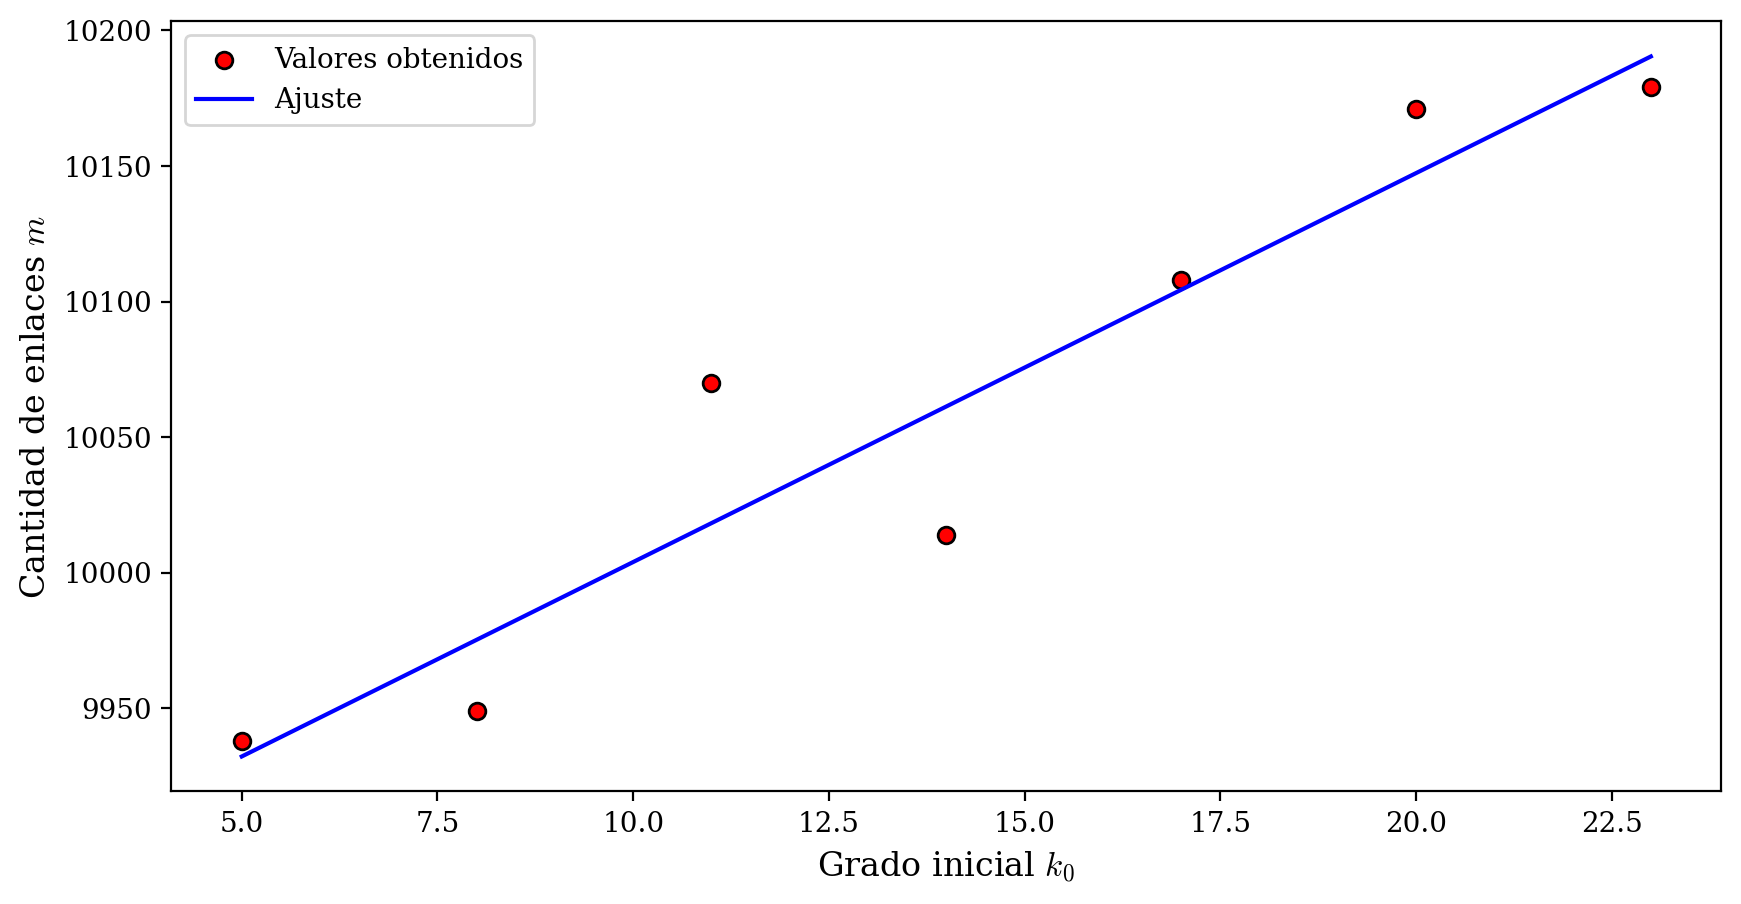

Pendiente = 14.3452391251536 (Esperado 10000)
Ordenada al origen = 9860.452366533566 (Esperado 0)


In [10]:
from scipy.optimize import curve_fit

k0_arr = np.array(list(range(5, 24, 3)))
m_vals = np.array(m_vals)

lineal = lambda x, a, b: a*x+b
popt, pcov = curve_fit(lineal, k0_arr, m_vals)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.scatter(k0_arr, m_vals, color = "red", label = "Valores obtenidos", ec="black")
plt.plot(k0_arr, lineal(k0_arr, *popt), color="blue", label="Ajuste")
plt.xlabel("Grado inicial $k_0$")
plt.ylabel("Cantidad de enlaces $m$")
plt.legend()
plt.show()

print(f"Pendiente = {popt[0]} (Esperado {N})")
print(f"Ordenada al origen = {popt[1]} (Esperado 0)")

# 4)

In [3]:
def plot_degree_dist(G):
    """
    Plot de la distribución de grados de este tipo de red.
    """

    degrees = dict(G.degree())
    degrees_dist = Counter(degrees.values())
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plt.scatter(degrees_dist.keys(), degrees_dist.values())

    return fig, ax